In [1]:
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import cv2

In [2]:
IMAGES_PATH = "covers-jpg/"

In [3]:
image_files = list(os.listdir(IMAGES_PATH))
print("Number of image files: {}".format(len(image_files)))

Number of image files: 5810


The image size is: (170, 255)


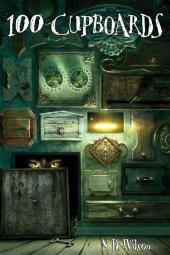

In [4]:
sample = Image.open('covers-jpg/10_100-cupboards-the-100-cupboards-book-1.jpg') 
print("The image size is: {}".format(sample.size))
sample

In [5]:
width = []
height = []
channels = []
for image in image_files: 
    img = cv2.imread(IMAGES_PATH+image)
    img = img.shape
    height.append(img[0])
    width.append(img[1])
    channels.append(img[2])

In [6]:
print("The average width of the covers is: {:.3f}".format(sum(width)/len(width)))
print("The average height of the covers is: {:.3f}".format(sum(height)/len(width)))
print("All {:d} images are in color".format(sum(map(lambda x : x == 3, channels))))

The average width of the covers is: 169.988
The average height of the covers is: 240.513
All 5810 images are in color


## Resize All Covers

In [7]:
!mkdir "covers-scaled"
new_path = "covers-scaled/"

mkdir: cannot create directory ‘covers-scaled’: File exists


In [8]:
for image in image_files:
    new_image = Image.open(IMAGES_PATH+image)
    new_image = new_image.resize((170, 240))
    new_image.save(new_path+image)

In [8]:
FAST_RUN = False
IMAGE_WIDTH=170
IMAGE_HEIGHT=240
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [10]:
width = []
height = []
channels = []
for image in image_files: 
    img = cv2.imread(IMAGES_PATH+image)
    img = img.shape
    height.append(img[0])
    width.append(img[1])
    channels.append(img[2])

In [11]:
print("The average width of the covers is: {:.3f}".format(sum(width)/len(width)))
print("The average height of the covers is: {:.3f}".format(sum(height)/len(width)))
print("All {:d} images are in color".format(sum(map(lambda x : x == 3, channels))))

The average width of the covers is: 169.988
The average height of the covers is: 240.513
All 5810 images are in color


In [12]:
filenames = os.listdir('covers-jpg')

titles = []
ratings = []
for filename in filenames:
    ratings.append(filename.split('_')[0])
    titles.append(filename.split('_')[1])


In [13]:
df = pd.DataFrame({
    'title': titles,
    'rating': ratings
})

In [14]:
df.head()

,title,rating
0,96-miles.jpg,10
1,dance-of-thieves-book-1.jpg,13
2,my-mom-is-trying-to-ruin-my-life.jpg,4
3,mortal-danger-the-immortal-game-book-1.jpg,13
4,ways-to-live-forever.jpg,11
